In [2]:
# Python standard packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import h5py

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. To achieve that we separate the effect of glitches from the effect of gaps in the Spritz data, and we do so by creating ad-hoc datasets with only gaps.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [3]:
# import data
fname = './data/LDC2_spritz_mbhb1_training_v2.h5'
# open file with h5py
fid = h5py.File(fname)

#### 1.1. Import the Spritz `tdi` datasets

The Spritz HDF5 file is structured in various groups:
- group `obs` containing `noise + signal + artifacts` (gaps + glitches)
- group `clean` containing `noise + signal`
- group `sky` containing `signal`
- group `noisefree` containing `signal + artifacts` (gaps + glitches)
- group `gal` containing galaxy confusion background

Each of these groups hosts a dataset `tdi` that contains TDI combinations $X$, $Y$ and $Z$.

#### and build additional TDI datasets
- TDI dataset `noise` containing clean noise
- TDI dataset `glitch` containing glitches
- TDI dataset `noiseglitch` containing `noise + glitch`
- TDI dataset `clean_gapped` containing `noise + signal + gaps`
- TDI dataset `noise_gapped` containing `noise + gaps`
- TDI dataset `sky_gapped` containing `sky + gaps`
- TDI dataset `noise_glitchgapped` containing `noise + glitch + gaps`


In [5]:
from bayesdawn.connect.fillgaps import load_tdi_timeseries, build_orthogonal_tdi, makeFDdata, generate_freq_data 

tdi = load_tdi_timeseries(fname = './data/LDC2_spritz_mbhb1_training_v2.h5')

print([x for x in tdi])

['obs', 'clean', 'sky', 'noisefree', 'gal', 'noise', 'glitch', 'noiseglitch', 'cleanglitch', 'clean_gapped', 'noise_gapped', 'sky_gapped', 'noiseglitch_gapped']


## 2. Format the data and save for to be available for lisabeta
 - We do this for each of the data versions which include the signal
 - We to 3-channel and 2 channel (no T) versions

In [12]:
basename='data/LDC2_spritz_mbhb1_v2'
versions=['clean','sky','clean_gapped','obs','glitch']
print('Working in',os.getcwd()) 
for ver in versions:
    print('Processing version',ver)
    td=build_orthogonal_tdi(tdi[ver])
    print('T=',(td['t'][-1]-td['t'][0])/(1-1/len(td['t'])))
    #Transform LDC data to Fourier domain
    fd=makeFDdata(td)
    #Convert to have all real columns
    rd=np.column_stack([fd['f'],fd['A'].real,fd['A'].imag,fd['E'].real,fd['E'].imag,fd['T'].real,fd['T'].imag])
    colnames='f,reA,imA,reE,imE,reT,imT'.split(',')
    #save
    fn=basename+'_'+ver+'_3chan.txt'
    print('Saving',fn)
    np.savetxt(fn,rd,header=' '.join(colnames))
    fn=basename+'_'+ver+'_2chan.txt'
    print('Saving',fn)
    np.savetxt(basename+'_'+ver+'_2chan.txt',rd[:,:-2],header=' '.join(colnames[:-2]))


Working in /data/jgbaker/MBHB/GapDev/spritz
Processing version clean
T= 2677900.0
Saving data/LDC2_spritz_mbhb1_v2_clean_3chan.txt
Saving data/LDC2_spritz_mbhb1_v2_clean_2chan.txt
Processing version sky
T= 2677900.0
Saving data/LDC2_spritz_mbhb1_v2_sky_3chan.txt
Saving data/LDC2_spritz_mbhb1_v2_sky_2chan.txt
Processing version clean_gapped
T= 2677900.0
Saving data/LDC2_spritz_mbhb1_v2_clean_gapped_3chan.txt
Saving data/LDC2_spritz_mbhb1_v2_clean_gapped_2chan.txt
Processing version obs
T= 2677900.0
Saving data/LDC2_spritz_mbhb1_v2_obs_3chan.txt
Saving data/LDC2_spritz_mbhb1_v2_obs_2chan.txt
Processing version glitch
T= 2677900.0
Saving data/LDC2_spritz_mbhb1_v2_glitch_3chan.txt
Saving data/LDC2_spritz_mbhb1_v2_glitch_2chan.txt


## 3. Generate a PSD estimate and format for lisabeta 
 - We first study the effect of possible frequency downsampling (down-averaging) on the PSD
 - We generate the PSD from the LDC noise data using bayesdawn tools
 - We downsample to a reasonable sized logarithmic grid
 - We save both 3-channel and 2 channel (no T) versions
 
 

In [5]:
from bayesdawn.psdmodel import ModelFDDataPSD
chans = ['A', 'E', 'T']
nc=len(chans)
psd_cls = []
dt=(tdi['noise']['t'][-1]-tdi['noise']['t'][0])/(len(tdi['noise']['t'])-1)
fs=1/dt

pf = np.array([-2.06121949e+06,  4.20988173e+05, -2.88082710e+04,  7.11239347e+02,
       -3.23216923e+00,  1.02536420e+00])
poly = np.poly1d(pf)

# instantiate the PSD noise class
fdata, psddata, scalefac=generate_freq_data(build_orthogonal_tdi(tdi['noise']))
for ch in chans:
    #psd_cls.append(LDCCorrectedModelPSD(len(tdi['noise']['t']), fs, noise_model = 'spritz', channel = ch, polyfit = poly))
    psd_cls.append(ModelFDDataPSD(fdata, ch, fit_type=None ))


### Downsample the model PSD for efficiency in lisabeta

Although we've decided to move this operation inside the lisabeta MBHBmcmc script, we test/demo  and apply it here.

In [6]:
from scipy.interpolate import interp1d,UnivariateSpline

##The following function will be applied within lisabeta code to downsample

def decimatePSD4spline(psd,n0=50,tol=1e-4,minf=None,maxf=None):
    '''
    Resample the PSD for economical use as lisabeta noise

    Arguments:
       psd    ndarrays with columns [f,ch1_PSD,ch2_PSD,...]
              frequencies are assumed to be identical for each channel
       n0     size of logarithmic starting grid  (def: 100)
       tol    err tolerance for determining whether more resolution is needed
       minf   min freq for output grid
       maxf   max freq for output grid

    Returns:
       a downsampled ndarray with same structure as input psd

    Internally, lisabeta uses splines for the inverse of the PSD. The
    inverse PSD is set to 0 outside the spline domain. Input data may 
    natively be signficantly oversampled.  This function downsamples and
    tests the resulting error on the original data, iteratively resampling
    as needed to ensure pointwise errors less than tol. The error is
    is computed on the inverse PSD relative to the max of the values 
    compared.

    The initial spline is logarithmic with size n0. For each spline segment 
    with any errors exceed the tolerance, a new spline point is drawn from the
    input grid near the segment bisection point. The process is repeated 
    iteratively until no such errors remain.  

    Barring zeros in the PSD, the algorithm must converge with the resulting
    length <= len(psd[0]).
    '''

    # Specify domain
    f=psd[:,0]
    if minf is None or minf<f[0]:  minf=f[0]
    if maxf is None or maxf>f[-1]: maxf=f[-1]
    mask=(f>=minf)&(f<=maxf)
    fm=f[mask]
    
    # Prepare the (first pass) grid
    # Begin with a log-sampled grid
    fgrid=np.logspace(np.log10(minf),np.log10(maxf),n0)
    # Now align these points with the data grid
    i0=0
    inds=[]
    for f in fgrid:
        ioff=np.searchsorted(fm[i0:],f)
        #print(i0,f,ioff)
        if ioff==len(fm[i0:]):ioff=len(fm[i0:])-1 
        if ioff>0:
            if ioff>=len(fm[i0:]):
                print('Whaaa?',ioff,len(fm[i0:]),fm[i0:][-1],f)
            inds.append(i0+ioff)
            i0+=ioff
            #print('added ',i0,fm[i0])
    fgrid=fm[inds]
    #print('snapped len',len(fgrid))
    #print('fgrid',fgrid)
    
    nc=psd.shape[1]-1
    psddown=[None]*nc

    #print(sum(mask))
    
    while True:
        # We start with the logarithmically downsampled grid.
        # Because may be some sharp features, the log-grid
        # may be insufficient.    
        # Thus we test the relative accuracy of the result
        # against tol within minf < f <max.
        # Wherever the condition fails, we add a spline point
        # at the midpoint of the existing points
        ok=np.ones_like(fm,dtype=bool)
        for i in range(nc):
            ch=chans[i]
            #downsample
            psddown[i]=psd[mask][inds][:,i+1]
            psdtest=psd[mask][:,i+1]
            #now the test
            invpsdfn=interp1d(fgrid,psddown[i]**-1,kind='cubic',fill_value='extrapolate')        
            psdint=invpsdfn(fm)
            truth=psdtest**-1
            err=np.abs(psdint-truth)/np.maximum(psdint,truth)
            ch_ok = ( err < tol )
            if False:
                npeek=10
                #print('fgrid',fgrid[:npeek])
                #print('psd[mask][inds,0]',psd[mask][inds,0][:npeek])
                #print('psddown',psddown[:npeek])
                #print('psd[mask][inds,i+1]',psd[mask][inds,i+1][:npeek])
                print(np.arange(len(err))[~ ch_ok][:npeek],'ch',i,'nonOKs')
                print(err[~ ch_ok][:npeek],'ch',i,'nonOKerr')
                print(psdint[~ ch_ok][:npeek],'ch',i,'nonOKpsdint')
                print(truth[~ ch_ok][:npeek],'ch',i,'nonOKtruth')
                print(fm[~ ch_ok][:npeek],'ch',i,'nonOKfm')
                print(psd[mask][~ ch_ok][:npeek,0],'ch',i,'nonOKPSDf')
                maxfpeek=0.007
                print('spline points',fgrid[fgrid<maxfpeek])
                print('spline vals',psddown[i][fgrid<maxfpeek])
                print('inds',np.array(inds)[fgrid<maxfpeek])
                print('fm[124:148]',fm[124:148])
                print('truth[124:148]',truth[124:148])
                print('psdint[124:148]',psdint[124:148])
            ok &= ch_ok
            #print('--> net oks:',sum(ok))
        nfails=sum(1-ok)
        #print(nfails,'fails')
        if nfails==0:
            #OK
            break
        else:
            #Now we add samples where needed
            newgrid=fgrid.copy()
            flast=0
            i=0
            while i <= len(newgrid):
                if i == len(newgrid):
                    fnext=fm[-1]
                else:
                    fnext = newgrid[i]
                here = (fm>flast) & (fm<fnext)
                if sum(1-ok[here])>0:
                    #print('interval',i,'is not OK:',flast,'< f <',fnext)
                    #need more in this interval
                    #Add a point in the original grid near the midpoint
                    f_here=fm[here]
                    fnew=f_here[len(f_here)//2]
                    #print('   inserting f =',fnew)
                    newgrid=np.insert(newgrid,i,fnew)                    
                    inew=np.argmax(here)+len(f_here)//2
                    inds=np.insert(inds,i,inew)
                    if False and i<50:
                        print('fcheck:',i,fnew,fm[inew],inew,len(f_here)//2,len(f_here))

                    i+=1
                flast=fnext
                i+=1
            fgrid=newgrid
        #print(len(fgrid))
        
    return np.column_stack([fgrid]+psddown)

1078
[3.06210090e-05 3.13678629e-05 3.28615706e-05]
(3, 1078)


(2.215991515238948e-49, 8.607284144392002e-45)

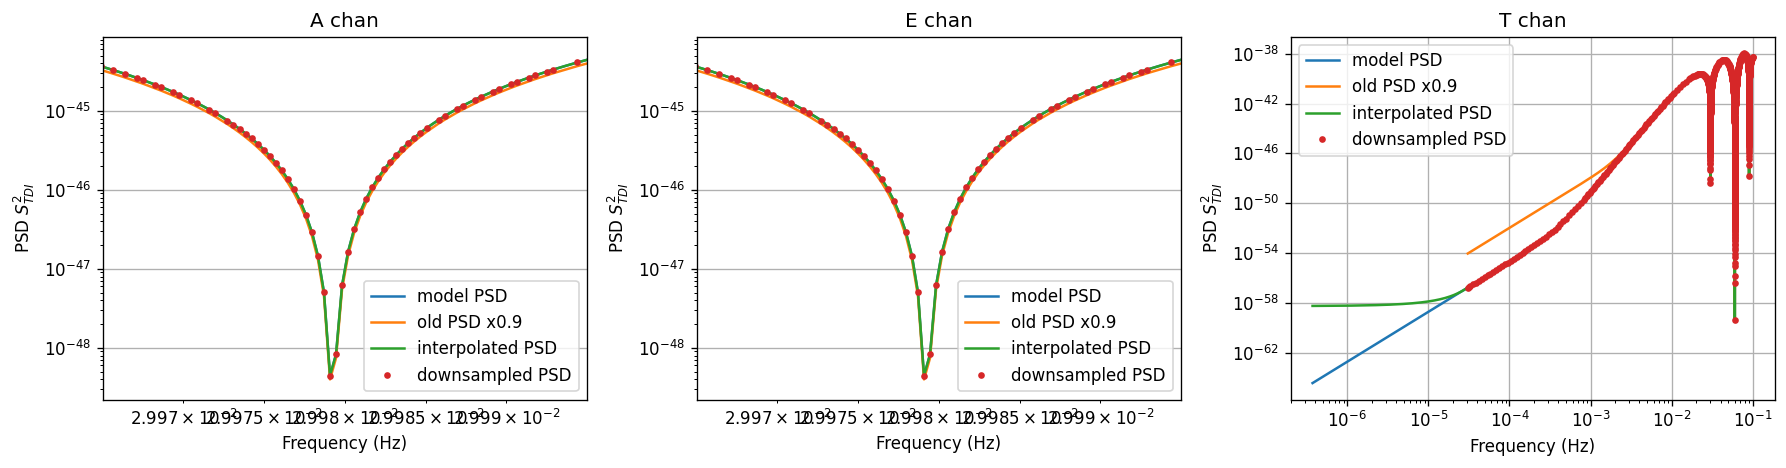

In [7]:
from scipy.signal import savgol_filter
alp=1
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='same')
    return y

fm=fdata['f']
psds_out=decimatePSD4spline(np.column_stack([fm]+[psd_cls[i].psd_fn(fm) for i in range(nc)]),n0=50,minf=3e-5,maxf=1e-1,tol=1e-3)
#psds_out=decimatePSD4spline(psds,n0=50,minf=3e-5,maxf=1e-1,tol=1e-3)
fgrid=psds_out[:,0]
psddown=psds_out[:,1:].T
print(len(fgrid))
print(fgrid[:3])
print(psddown.shape)

#Read in old version of PSD
old_psd=np.loadtxt('LDC2_spritz_mbhb1_training_v1b_noise_PSD_3chan.txt')

#plot
fig, ax = plt.subplots(1,nc,figsize=(15,4),dpi=120, sharey=False, squeeze=False)


mask=np.arange(len(fm))%1==0
for i in range(nc):
    ch=chans[i]
    label=''
    k=0
    modelPSD=psd_cls[i].psd_fn(fm) 
    ax[k,i].loglog(fm[mask],modelPSD, label='model PSD',alpha=alp)
    ax[k,i].set_xlabel('Frequency (Hz)')
    ax[k,i].set_ylabel(r'PSD $S^2_{TDI}$')
    ax[k,i].set_title(ch+' chan')
    ax[k,i].grid()
    invpsdfn=interp1d(fgrid,psddown[i]**-1,kind='cubic',fill_value='extrapolate')
    psdint=invpsdfn(fm)**-1
    ax[k,i].loglog(old_psd[:,0],old_psd[:,i+1]*0.9, label='old PSD x0.9',alpha=alp)
    ax[k,i].loglog(fm[mask],psdint[mask], label='interpolated PSD',alpha=alp)
    ax[k,i].loglog(fgrid,psddown[i], '.', label='downsampled PSD')
    ##psdsm=UnivariateSpline(fm[mask],modelPSD,w=1/modelPSD,s=100)(fm[mask])
    ##psdsm=savgol_filter(modelPSD,60,3)
    w=np.hanning(11)
    smooth=lambda s:np.convolve(w/w.sum(),s,mode='same')
    psdsm=smooth(modelPSD)
    #ax[k,i].loglog(fm[mask],psdsm, label='smoothed',alpha=alp)
    ax[k,i].legend()
fig.tight_layout()
f0view=0.02998
view_width=0.0005
view=(f0view*(1-view_width),f0view*(1+view_width))
fmview=(fm>view[0]) & (fm <view[1])
yview=(min(psdint[fmview])/2,max(psdint[fmview])*2)
ax[0,0].set_xlim(view)
ax[0,0].set_ylim(yview)
ax[0,1].set_xlim(view)
ax[0,1].set_ylim(yview)

### Apply downsampling and save

Doing both 2 and 3 channel versions

In [8]:
basename='LDC2_spritz_mbhb1_training_v2_noise_PSD'
colnames='f,PSD_A,PSD_E,PSD_T'.split(',')
#save
for nc in [2,3]:
    fn=basename+'_'+str(nc)+'chan.txt'
    print('Saving',fn)
    psdarray=decimatePSD4spline(np.column_stack([fm]+[psd_cls[i].psd_fn(fm) for i in range(nc)]),n0=50,minf=3e-5,maxf=1e-1,tol=1e-3)
    np.savetxt(fn,psdarray,header=' '.join(colnames[:nc+1]))


Saving LDC2_spritz_mbhb1_training_v2_noise_PSD_2chan.txt
Saving LDC2_spritz_mbhb1_training_v2_noise_PSD_3chan.txt


In [11]:
!pwd
import os
os.getcwd() 

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/jgbaker/data/MBHB/GapDev/spritz


'/data/jgbaker/MBHB/GapDev/spritz'